# Introduction

### Problem Description

Aging can be considered as a disease. From such point of view there can exist remedies for it. They are called geroprotectors. Being more rigorous, geroprotectors are drugs (or drug-like compounds) that slow down aging processes.

Species with Latin name Caenorhabiditis elegans (roundworm in English) is an object of several experiments aimed to measure effect of different drugs on mean, median, and maximum lifespan. Below these experimental data are used and further in this presentation the word 'geroprotector' means a compound that has positive impact on roundworms' lifespan.

The goal of the current study is to generate a list of compounds that are not marked as known geroprotectors, but with high probability are geroprotectors. In other words, the task is to extend given list of geroprotectors by finding new ones.

The methodology is based on PU-learning (positive vs. unlabeled learning). Unlike in the case of binary classification, there are no initially given negative examples - there are only positive and unlabeled examples. However, we treat unlabeled examples as if they were negative. This leads to irrelevance of accuracy score, because labeling a negative example with positive label can be a mistake and can be a right decision. It is better to use ROC-AUC, since it depends only on examples' ranking by probability of belonging to the positive class. Also it is sometimes possible to weight classes in order to penalize false negatives heavier than false positives. Finally, when classificator is built, negative examples with high estimated probability of positive label are delivered as new positive examples.

The main limitation of the study is that only chemical features of compounds are involved. For example, some compounds are cures if concentration is low, but become poisonous if concentration is high. However, here concentration is not used. Features derived from interaction between a drug and organism's cells are not used as well. Perhaps, this will be fixed in the future. 

### Data Sources

File *geroprotectors.csv* is based on Curated Database of Geroprotectors: http://geroprotectors.org/

File *zinc_smiles.csv* is based on ZINC Database: http://zinc.docking.org/browse/subsets/

### References

For more details on geroprotectors' search please look at:

*Moskalev A, Zhavoronkov A, et al. In search for geroprotectors: in silico screening and in vitro validation of signalome-level mimetics of young healthy state (2016).*

# Preparations

### General

In [1]:
from itertools import product
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from rdkit.Chem import MolFromSmiles, rdMolDescriptors
from rdkit.DataStructs import ConvertToNumpyArray

In [2]:
np.random.seed(seed=187)

### Data Extraction, Data Transformation, and Sanity Checkups

In [3]:
df = pd.read_csv('external_data/geroprotectors.csv', sep='\t')
df.head()

,Name,SMILES,Mean,Median,Max
0,Amoxapine,Clc1ccc2Oc3ccccc3N=C(N4CCNCC4)c2c1,33.00,NaN,NaN
1,Amperozide Hydrochloride,Cl.CCNC(=O)N1CCN(CCCC(c2ccc(F)cc2)c3ccc(F)cc3)CC1,38.00,NaN,NaN
2,Ascorbic Acid,OC[C@H](O)[C@H]1OC(=O)C(=C1O)O,66.67,NaN,NaN
3,Aspirin,CC(=O)Oc1ccccc1C(=O)O,23.00,NaN,NaN
4,Bacitracin,CC[C@H](C)[C@H](N)C1=N[C@@H](CS1)C(=O)N[C@@H](...,NaN,NaN,74.0


Are there any duplicates?

In [4]:
len(df.index)

141

In [5]:
len(df['Name'].unique())

141

In [6]:
len(df['SMILES'].unique())

141

How many compounds have more than one statistics measured?

In [7]:
len(df[pd.notnull(df['Mean']) & pd.notnull(df['Median']) & pd.notnull(df['Max'])])

2

In [8]:
len(df[pd.notnull(df['Mean']) & pd.notnull(df['Median'])])

5

In [9]:
len(df[pd.notnull(df['Mean']) & pd.notnull(df['Max'])])

20

Are there any abnormal values?

In [10]:
df.describe()

,Mean,Median,Max
count,123.000000,20.000000,28.000000
mean,22.850488,31.879500,31.574643
std,13.247925,19.306042,22.548757
min,3.100000,10.000000,0.100000
25%,13.000000,17.600000,12.067500
50%,19.000000,23.445000,26.100000
75%,31.500000,44.250000,49.750000
max,73.330000,70.000000,78.000000


Let us convert SMILES to binary features.

In [11]:
def smiles_to_numpy(smiles, radius=2):
    """
    Takes Morgan fingerprints for each
    element of `smiles` and packs them
    to numpy array.
    
    Morgan fingerprints are chosen,
    because they provide fixed length
    of bit vectors.
    
    @type smiles: pandas.Series
    @type radius: integer
    @return: numpy.ndarray
    """
    molecules = map(MolFromSmiles, smiles.tolist())
    to_morgan = partial(rdMolDescriptors.GetMorganFingerprintAsBitVect,
                        radius=radius)
    fingerprints = map(to_morgan, molecules)
    
    # However, RDKit does not fit in functional paradigm.
    np_fingerprints = []
    for fingerprint in fingerprints:
        arr = np.zeros((1,))
        ConvertToNumpyArray(fingerprint, arr)
        np_fingerprints.append(arr)
    result = np.vstack(tuple(np_fingerprints))
    return result

In [12]:
geroprotectors = smiles_to_numpy(df['SMILES'])

In [13]:
geroprotectors.shape

(141, 2048)

Now do the same for a random collection of molecules.

In [14]:
zinc_smiles = pd.read_csv('external_data/zinc_smiles.csv')
zinc_smiles.head()

,SMILES
0,c1ccc(cc1)C(c2ccccc2)[S@](=O)CC(=O)NO
1,CCC[S@](=O)c1ccc2c(c1)[nH]/c(=N\C(=O)OC)/[nH]2
2,c1c2c(cc3c1OCO3)[C@@H]4[C@H]([C@@H](C=C5[C@@H]...
3,C[C@@H](CC(c1ccccc1)(c2ccccc2)C(=O)N)[NH+](C)C
4,Cc1c(c(=O)n(n1C)c2ccccc2)NC(=O)[C@H](C)[NH+](C)C


In [15]:
random_indices = np.random.choice(np.arange(len(zinc_smiles.index)), size=5000, replace=False)
random_indices

array([ 642498,  562879,  209244, ..., 1028227,   12567,  970906])

In [16]:
random_smiles = zinc_smiles.iloc[random_indices, :]
random_smiles.head()

,SMILES
642498,Cc1ccc(c(c1)[C@H](C)NC(=O)CC2(CCCC2)C(=O)[O-])OC
562879,Cc1c(c(n(n1)c2ccccc2)C)C(=O)OCc3ccccc3OC
209244,COc1cccc(c1OC)/C=C(\C#N)/c2ccccc2[N+](=O)[O-]
133601,Cn1c(nnc1SCC(=O)N2CCCC2)CCc3ccccc3
55416,c1cc(ccc1/C=N/NC(=O)c2cc(ccc2[O-])[N+](=O)[O-]...


In [17]:
len(random_smiles['SMILES'].unique())

5000

In [18]:
random_compounds = smiles_to_numpy(random_smiles['SMILES'])

In [19]:
random_compounds.shape

(5000, 2048)

Are there any duplicates (not for SMILES, but for fingerprints)? Do samples overlap?

In [20]:
unique_gp = np.vstack({tuple(row) for row in geroprotectors}).shape[0]

try:
    assert unique_gp == geroprotectors.shape[0]
except AssertionError:
    print "# of duplicated fingerprints for geroprotectors: {}.".format(
        geroprotectors.shape[0] - unique_gp)
else:
    print "There are no duplicated fingerprints for geroprotectors."

There are no duplicated fingerprints for geroprotectors.


In [21]:
unique_rc = np.vstack({tuple(row) for row in random_compounds}).shape[0]

try:
    assert unique_rc == random_compounds.shape[0]
except AssertionError:
    print "# of duplicated fingerprints for random compounds: {}.".format(
        random_compounds.shape[0] - unique_rc)
else:
    print "There are no duplicated fingerprints for random compounds."

# of duplicated fingerprints for random compounds: 8.


In [22]:
unique_all = np.vstack({tuple(row)
                        for row in np.vstack((geroprotectors, random_compounds))}).shape[0]

try:
    assert unique_all == unique_gp + unique_rc
except AssertionError:
    print "Length of intersection between two samples: {}.".format(
        unique_gp + unique_rc - unique_all)
else:
    print "There is no intersection between geroprotectors and random compounds."

There is no intersection between geroprotectors and random compounds.


Although *random_compounds* has duplicate fingerprints (e.g. due to hash collisions), there is an empty intersection between randomly chosen compounds and known geroprotectors. Try random seed 128500 to have a non-empty intersection.

In [23]:
positives = np.hstack((geroprotectors, np.ones((geroprotectors.shape[0], 1))))
negatives = np.hstack((random_compounds, np.zeros((random_compounds.shape[0], 1))))
sample = np.vstack((positives, negatives))
sample.shape

(5141, 2049)

In [24]:
border = positives.shape[0]

# Exploratory Analysis

### Single bits importance

Below hypothesis that some bits of fingerprints allows separating geroprotectors, is tested.

In [25]:
scores = {}
for i in range(sample.shape[1] - 1):
    scores[i] = roc_auc_score(sample[:, -1], sample[:, i])

In [26]:
n_to_print = 10
for position in sorted(scores, key=scores.get, reverse=True)[:n_to_print]:
    print "Bit position: {}, ROC-AUC: {}".format(position, scores[position])

Bit position: 1602, ROC-AUC: 0.589675177305
Bit position: 1607, ROC-AUC: 0.57335248227
Bit position: 389, ROC-AUC: 0.569990070922
Bit position: 352, ROC-AUC: 0.559760283688
Bit position: 1844, ROC-AUC: 0.557983687943
Bit position: 1538, ROC-AUC: 0.556137588652
Bit position: 1979, ROC-AUC: 0.555137588652
Bit position: 1257, ROC-AUC: 0.554329787234
Bit position: 222, ROC-AUC: 0.553975886525
Bit position: 1171, ROC-AUC: 0.549490780142


In [27]:
for position in sorted(scores, key=scores.get)[:n_to_print]:
    print "Bit position: {}, ROC-AUC: {}".format(position, scores[position])

Bit position: 1152, ROC-AUC: 0.322975177305
Bit position: 378, ROC-AUC: 0.354021985816
Bit position: 1917, ROC-AUC: 0.362758156028
Bit position: 1816, ROC-AUC: 0.379292198582
Bit position: 1057, ROC-AUC: 0.384365248227
Bit position: 1750, ROC-AUC: 0.395033333333
Bit position: 1722, ROC-AUC: 0.39799929078
Bit position: 650, ROC-AUC: 0.400825531915
Bit position: 1873, ROC-AUC: 0.415970921986
Bit position: 1380, ROC-AUC: 0.41904751773


After reverting predictions ROC-AUC over 67% is reached solely by feature 1152 for all tested random seeds. They are as follows: 19, 26, 44, 361, 1001.

In [28]:
np.mean(positives[:, 1152])

0.22695035460992907

In [29]:
np.mean(negatives[:, 1152])

0.58099999999999996

Thus, there is no silver bullet amongst the features, but there are relationships between the target and the features.

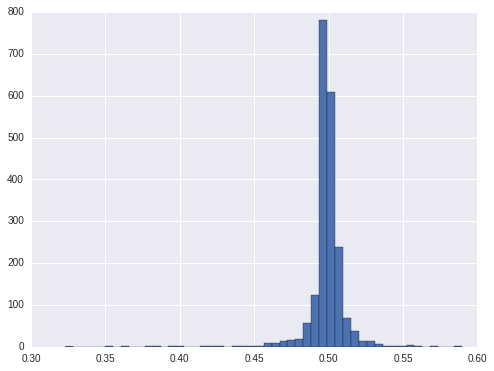

In [30]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
_ = ax.hist([scores[key] for key in scores.keys()], 50)

More than half of the features seem like they are useless. Why not remove them?

In [31]:
filter_features = False
if filter_features:
    relevant_features = [key for key in scores.keys() if abs(scores[key] - 0.5) > 0.01]
    positives = positives[:, relevant_features]
    negatives = negatives[:, relevant_features]
    sample = sample[:, relevant_features]
    sample.shape

### Similarities' study

In [32]:
subsample_size = 10
random_positives = positives[np.random.choice(np.arange(positives.shape[0]),
                                              size=subsample_size, replace=False), :]
random_negatives = negatives[np.random.choice(np.arange(negatives.shape[0]),
                                              size=subsample_size, replace=False), :]
random_subsample = np.vstack((random_positives, random_negatives))[:, :-1]
random_subsample.shape

(20, 2048)

In [33]:
def tanimoto_similarity(first, second):
    """
    Computes Tanimoto similarity of two arrays.
    
    It is defined as a ratio of number of bits
    active in both arrays to number of bits
    active in at least one array.
    
    @type first: numpy.ndarray
    @type second: numpy.ndarray
    @return: float
    """
    bool_first = first.astype(bool)
    bool_second = second.astype(bool)
    intersection_length = np.sum(np.bitwise_and(bool_first, bool_second).astype(int))
    union_length = np.sum(np.bitwise_or(bool_first, bool_second).astype(int))
    return float(intersection_length) / union_length

In [34]:
tanimoto_matrix = np.zeros((2 * subsample_size, 2 * subsample_size))
for i, j in product(range(2 * subsample_size), range(2 * subsample_size)):
    tanimoto_matrix[i, j] = tanimoto_similarity(random_subsample[i, :], random_subsample[j, :])

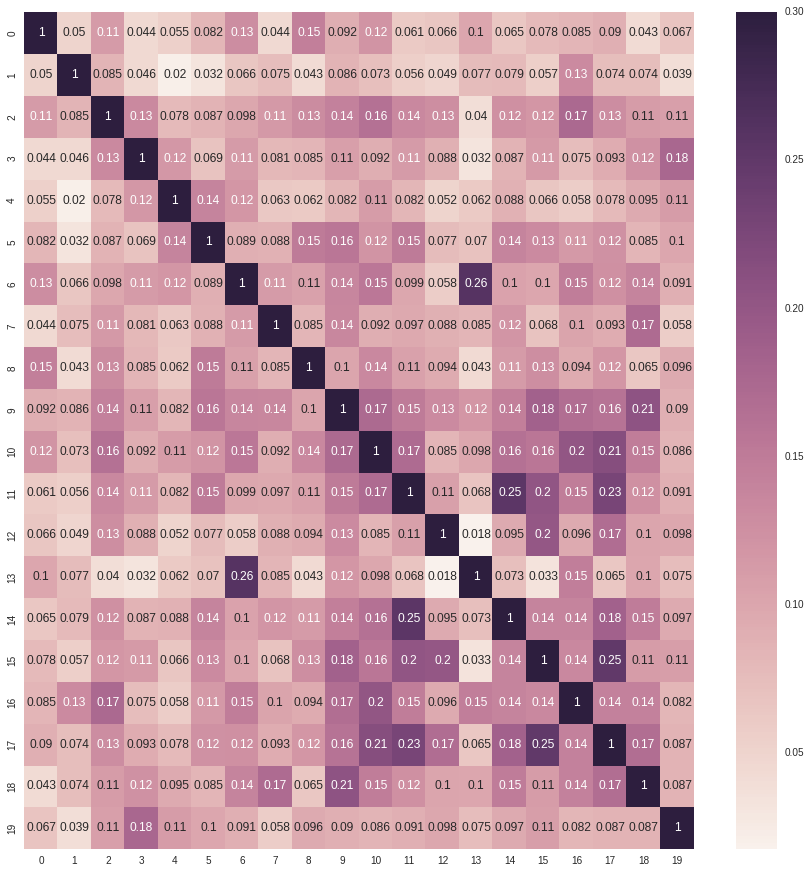

In [35]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
_ = sns.heatmap(tanimoto_matrix, ax=ax, annot=True, vmax=0.3)

As it can be seen, known geroprotectors are dissimilar to each other at the same extent as they are dissimilar to random compounds.

### Dimensionality reduction

In [36]:
weights = np.array([abs(scores[key] - 0.5) for key in scores.keys()])
weighted_positives = positives[:, :-1] * weights
weighted_negatives = negatives[:, :-1] * weights
weighted_sample = sample[:, :-1] * weights

In [37]:
pca = PCA(n_components=10, random_state=361)
# TODO: Exclude target if sample is not weighted.
pca.fit(weighted_sample)
pca.explained_variance_ratio_

array([ 0.24970624,  0.13394864,  0.08118268,  0.07111638,  0.04893335,
        0.03876245,  0.03780025,  0.02949835,  0.02205192,  0.01898344])

In [38]:
pca = PCA(n_components=2, random_state=361)
pca.fit(weighted_sample)
pcaed_positives = pca.transform(weighted_positives)
pcaed_negatives = pca.transform(weighted_negatives)

In [49]:
pca = PCA(n_components=2, random_state=361)
roc_auc_score(sample[:, -1], pca.fit_transform(weighted_sample)[:, 0] - pca.fit_transform(weighted_sample)[:, 1])

0.80354609929078014

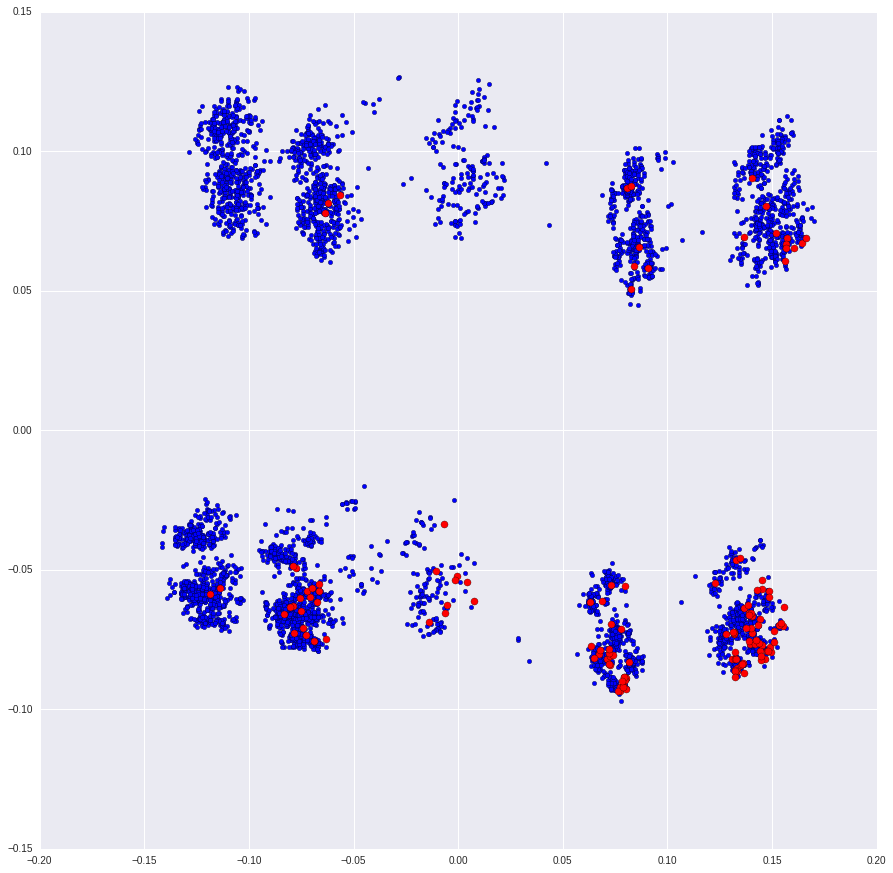

In [39]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
ax.scatter(pcaed_negatives[:, 0], pcaed_negatives[:, 1])
ax.scatter(pcaed_positives[:, 0], pcaed_positives[:, 1], c='Red', s=50)

Above picture looks pessimistic, because geroprotectors are densely surrounded by other compounds.

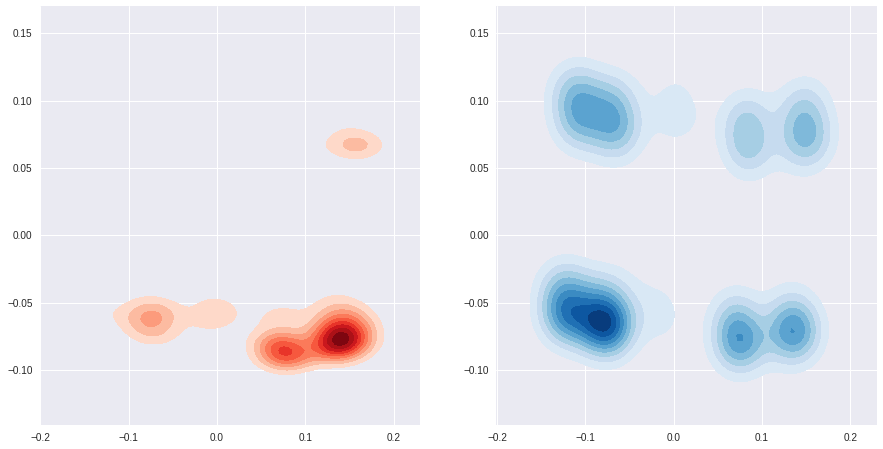

In [40]:
fig = plt.figure(figsize=(15, 7.5))
ax_one = fig.add_subplot(121)
sns.kdeplot(pcaed_positives[:, 0], pcaed_positives[:, 1],
            cmap='Reds', shade=True, shade_lowest=False, ax=ax_one)
ax_two = fig.add_subplot(122, sharex=ax_one, sharey=ax_one)
sns.kdeplot(pcaed_negatives[:, 0], pcaed_negatives[:, 1],
            cmap='Blues', shade=True, shade_lowest=False, ax=ax_two)

This new picture looks more optimistic, because peak of density for geroprotectors differs from that of random compounds. Unfortunately, the result is unstable - other random seeds can lead to absence of the pattern.

In [41]:
pca = PCA(n_components=20, random_state=361)
pcaed_sample = pca.fit_transform(weighted_sample)

In [42]:
tsne = TSNE(n_components=2, random_state=361)
tsned_sample = tsne.fit_transform(pcaed_sample)
tsned_positives = tsned_sample[:border, :]
tsned_negatives = tsned_sample[border:, :]

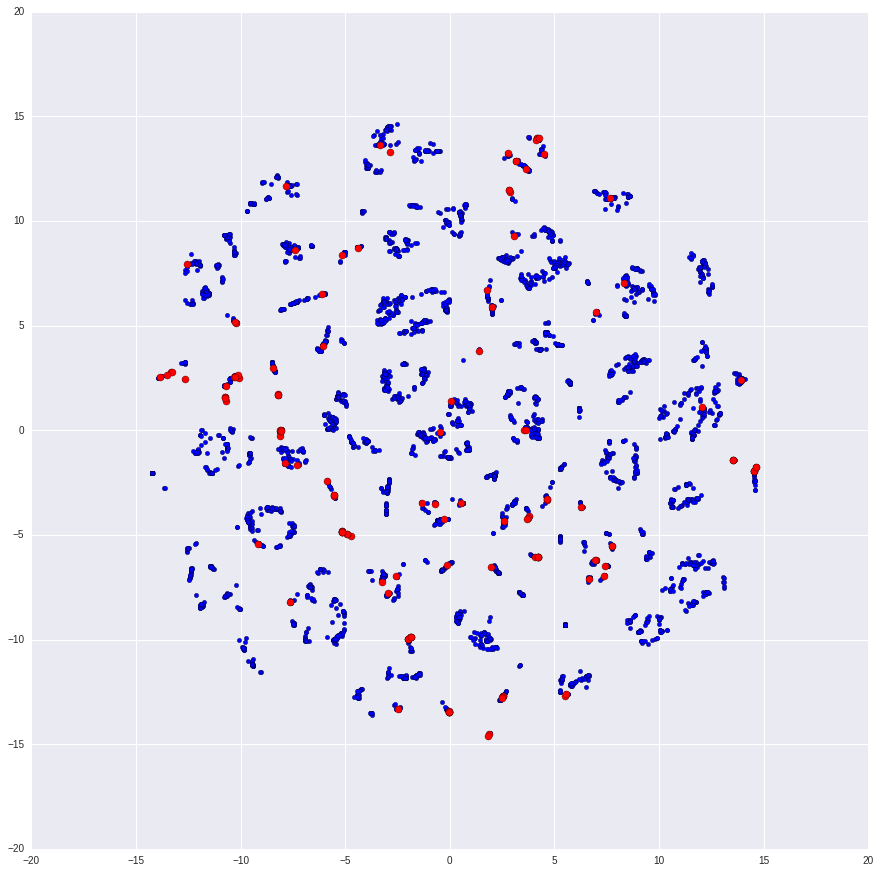

In [43]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
ax.scatter(tsned_negatives[:, 0], tsned_negatives[:, 1])
ax.scatter(tsned_positives[:, 0], tsned_positives[:, 1], c='Red', s=50)

Geroprotectors are concentrated predominantly at the one side of the picture (here at the upper part). This pattern is less sensitive to choice of random seed.

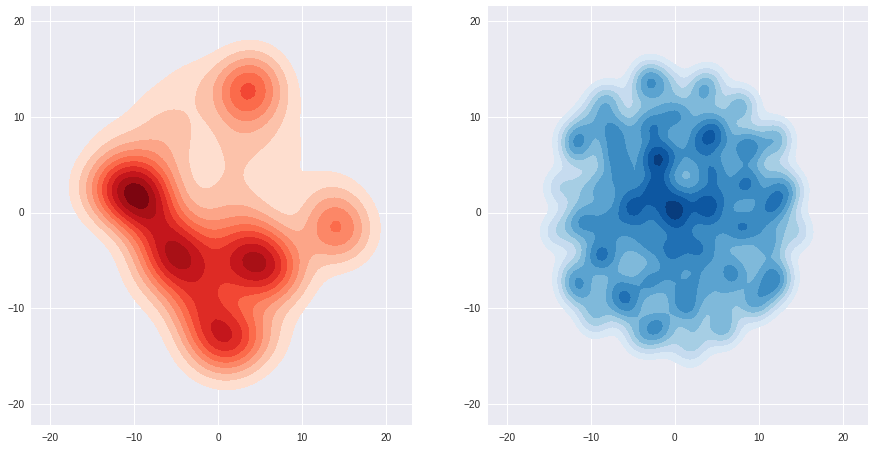

In [44]:
fig = plt.figure(figsize=(15, 7.5))
ax_one = fig.add_subplot(121)
sns.kdeplot(tsned_positives[:, 0], tsned_positives[:, 1],
            cmap='Reds', shade=True, shade_lowest=False, ax=ax_one)
ax_two = fig.add_subplot(122, sharex=ax_one, sharey=ax_one)
sns.kdeplot(tsned_negatives[:, 0], tsned_negatives[:, 1],
            cmap='Blues', shade=True, shade_lowest=False, ax=ax_two)

Here peaks of density for geroprotectors and random compounds do not overlap and this is a sustainable pattern.

In [45]:
# To be continued.

# TODO: Compute how many points of each class are in correct PCA-cluster.
# TODO: Use principal components as features, but compute them only on training set.